# Supervised ML Classifiers for Tanzanian Water Well Condition

## 1 Introduction

### 1.1 Problem Statement

### 1.2 Objectives

#### 1.2.1 Goal

#### 1.2.2 Specific Objectives

## 2 Exploratory Data Analysis (EDA)

### 2.1 Data Loading and Feature Selection


Load datasets, feature selection, and preliminary data cleaning 

In [56]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set(style="whitegrid")

In [57]:
# Load datasets
train_features = pd.read_csv("./data/trainingset.csv")
train_labels = pd.read_csv("./data/trainingsetlabels.csv")

# Merge features and labels for EDA
train_df = pd.merge(train_features, train_labels, on="id")

# Display first few rows
train_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [65]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     59400 non-null  int64 
 1   date_recorded          59400 non-null  object
 2   gps_height             59400 non-null  int64 
 3   basin                  59400 non-null  object
 4   region                 59400 non-null  object
 5   population             59400 non-null  int64 
 6   permit                 56344 non-null  object
 7   construction_year      59400 non-null  int64 
 8   extraction_type_class  59400 non-null  object
 9   management_group       59400 non-null  object
 10  payment_type           59400 non-null  object
 11  water_quality          59400 non-null  object
 12  quantity               59400 non-null  object
 13  source_type            59400 non-null  object
 14  waterpoint_type_group  59400 non-null  object
 15  status_group       

In [60]:
# Drop columns deemed irrelevant to this project
train_df = train_df.drop(columns = ['amount_tsh', 'funder', 'installer', 'latitude', 'longitude', 'scheme_name', 'wpt_name', 'num_private', 'subvillage', 'region_code', 'district_code', 'lga', 'ward', 'public_meeting', 'recorded_by'])

In [61]:
# Drop redundant columns
train_df = train_df.drop(columns =['scheme_management', 'extraction_type', 'extraction_type_group', 'management', 'payment', 'quality_group', 'quantity_group', 'source', 'source_class', 'waterpoint_type'])

In [62]:
# Check for missing values
missing = train_df.isnull().sum()
missing_percent = (missing / len(train_df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing, 'Percent': missing_percent})
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values(by='Percent', ascending=False)
missing_df

,Missing Values,Percent
permit,3056,5.144781


In [63]:
# Check training dataset shape
train_df.shape
print(f"Training dataset consists of: {train_df.shape[0]} rows")
print(f"Training dataset consists of: {train_df.shape[1]} columns")

Training dataset consists of: 59400 rows
Training dataset consists of: 16 columns


In [66]:
# Due to large dataset size, drop all rows with missing values
train_df = train_df.dropna()

In [67]:
# Verify that rows with missing values are removed
train_df.isna().sum()

id                       0
date_recorded            0
gps_height               0
basin                    0
region                   0
population               0
permit                   0
construction_year        0
extraction_type_class    0
management_group         0
payment_type             0
water_quality            0
quantity                 0
source_type              0
waterpoint_type_group    0
status_group             0
dtype: int64

In [68]:
# Recheck training dataset shape
train_df.shape
print(f"Training dataset consists of: {train_df.shape[0]} rows")
print(f"Training dataset consists of: {train_df.shape[1]} columns")

Training dataset consists of: 56344 rows
Training dataset consists of: 16 columns


### 2.2 Feature Engineering

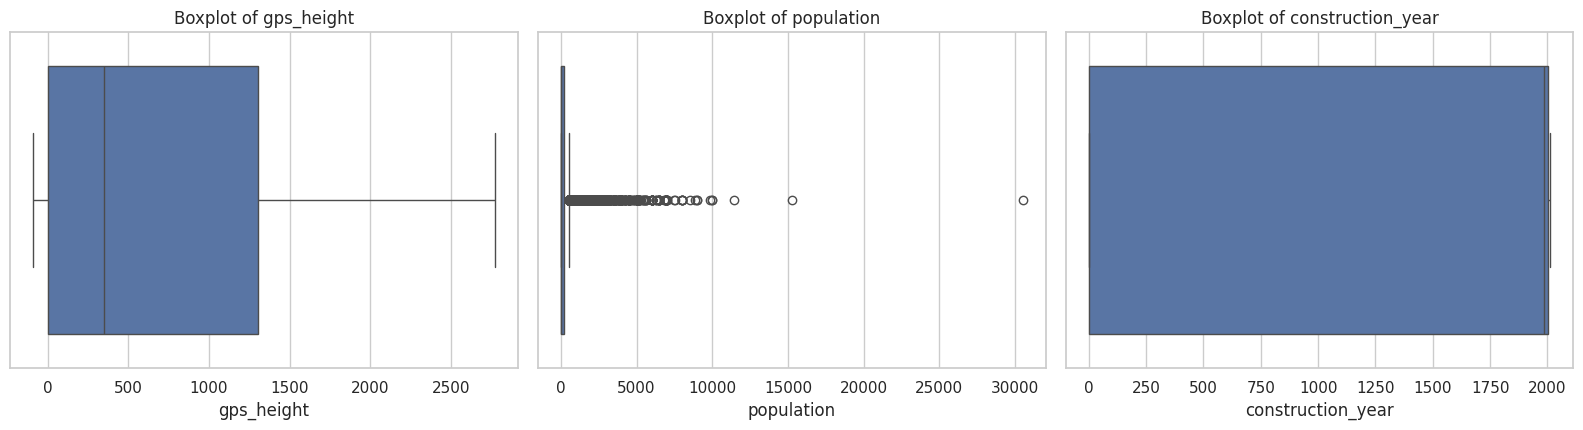

In [69]:
# Define numerical columns (excluding 'id')
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('id')

# Visualize outliers for selected numerical features using boxplots
plt.figure(figsize=(16, 8))
for i, col in enumerate(num_cols[:6]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=train_df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

#### 2.2.1 Engineer `well_age` Feature

A well's age is an important predictor on it condition. Although the feature is not included in the training.csv dataset; it can be engineered by convering the `date_recorded` variable to datetime and substracting the value from a well's construction year.

In [70]:
# Check unique values for `construction_year` feature
train_df['construction_year'].unique()

array([1999, 2010, 2009, 1986,    0, 2011, 1987, 1991, 1978, 1992, 2008,
       1974, 2000, 2002, 2004, 1972, 2003, 2007, 1973, 1985, 1995, 2006,
       1962, 2005, 1997, 1970, 1996, 1977, 1983, 2012, 1984, 1982, 1976,
       1988, 1989, 1975, 1960, 1990, 1961, 1998, 1963, 1971, 1994, 1968,
       1980, 1993, 2001, 1979, 1967, 1969, 1981, 2013, 1964, 1966, 1965])

In [71]:
# Drop all row entries with a value of 0 in the column `construction_year`
train_df.drop(train_df[train_df['construction_year'] == 0].index, inplace=True)

In [72]:
# Recheck training dataset shape
train_df.shape
print(f"Training dataset consists of: {train_df.shape[0]} rows")
print(f"Training dataset consists of: {train_df.shape[1]} columns")

Training dataset consists of: 36764 rows
Training dataset consists of: 16 columns


In [73]:
# Convert 'date_recorded' to datetime year
train_df['date_recorded'] = pd.to_datetime(train_df['date_recorded']).dt.year

# Calculate well_age = date_recorded - construction_year
train_df['well_age'] = train_df['date_recorded'] - train_df['construction_year']

In [74]:
# Confirm the Engineered feature accurately captures a well's age by the date the data was recorded
train_df[['date_recorded', 'construction_year', 'well_age']].head()

,date_recorded,construction_year,well_age
0,2011,1999,12
1,2013,2010,3
2,2013,2009,4
3,2013,1986,27
5,2011,2009,2


In [75]:
 # Drop 'construction_year' and 'date_recorded' features from train_df
train_df = train_df.drop(columns=['construction_year', 'date_recorded'])

In [76]:
train_df['well_age'].describe()

count    36764.000000
mean        15.245186
std         12.467690
min         -7.000000
25%          4.000000
50%         12.000000
75%         25.000000
max         53.000000
Name: well_age, dtype: float64

- The entries with a negative value for the `well-age` feature are not feasible and are dropped from train_df

In [77]:
# Drop all row entries whose values for 'well_age' are less than zero
train_df = train_df[train_df['well_age'] >= 0]

#### 2.2.2 Multicollinearity Check
- Highly correlated numerical features leads to multicolinearity. Training supervised ML classifiers with highly correlated numerical features increases computational complexity, and elevates the risk for overfitting. 
- Additionally, multicollinearity leads to uncertainity in determining the true contribuction of each feature to predictions.
- Correlation measures are highly sensitive to outliers.

In [78]:
# Identify numerical columns after engineering features
num_cols_1 = train_df.select_dtypes(include=[np.number]).columns.tolist()
num_cols_1.remove('id')

# Remove outliers
for col in num_cols_1:
    lower = train_df[col].quantile(0.01)
    upper = train_df[col].quantile(0.99)
    train_df = train_df[(train_df[col] >= lower) & (train_df[col] <= upper)]


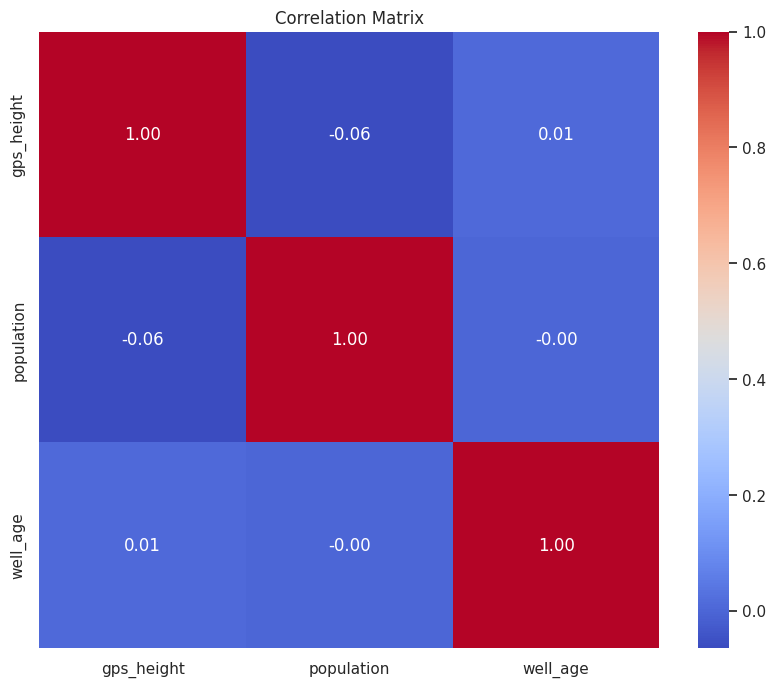

In [79]:
# Plot the correlation matrix
corr = train_df[num_cols_1].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

- There is no multicolineariry among the numerical variables. 
- For inclusion alongside the OneHotEncoded categorical features; these numerical variables must be standardized. 
- The MinMaxScaller is selected because it scales numerical features between 0 and 1. Hence, the scaled numerical features will lie within the same range as the OneHotEncoded dummy variables for categorical features. 

In [86]:
scaler = MinMaxScaler()
train_df[num_cols_1] = scaler.fit_transform(train_df[num_cols_1])

#### 2.2.3 Label-Encoding The Target variable and OneHot-Encoding Categorical Features

In [81]:
# Encode target variable and Feature Engineer its name
le = LabelEncoder()
train_df['status_group_encoded'] = le.fit_transform(train_df['status_group'])

In [84]:
# Define categorical features
cat_cols = train_df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('status_group')
    

In [85]:
cat_cols

['basin',
 'region',
 'permit',
 'extraction_type_class',
 'management_group',
 'payment_type',
 'water_quality',
 'quantity',
 'source_type',
 'waterpoint_type_group']

In [87]:
# One-hot encode categorical features
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
cat_features = ohe.fit_transform(train_df[cat_cols])
cat_feature_names = ohe.get_feature_names_out(cat_cols)
cat_df = pd.DataFrame(cat_features, columns=cat_feature_names, index=train_df.index)

# Concatenate one-hot encoded features with the rest of the DataFrame
train_df_encoded = pd.concat([
    train_df.drop(columns=cat_cols),
    cat_df
], axis=1)

In [88]:
train_df_encoded.head()

,id,gps_height,population,status_group,well_age,status_group_encoded,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,...,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,69572,0.642306,0.045417,functional,0.272727,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,8776,0.646391,0.116667,functional,0.068182,0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,34310,0.322742,0.104167,functional,0.090909,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,67743,0.130731,0.024167,non functional,0.613636,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,9944,0.011348,0.000417,functional,0.045455,0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [89]:
# Check shape
train_df_encoded.shape
print(f"Training dataset consists of: {train_df_encoded.shape[0]} rows")
print(f"Training dataset consists of: {train_df_encoded.shape[1]} columns")

Training dataset consists of: 35327 rows
Training dataset consists of: 69 columns


#### 2.2.4 Define Exog, Endog, and Train-Test Split

In [90]:
# Split data into features and target
y = train_df_encoded['status_group_encoded']
X = train_df_encoded.drop(['id', 'status_group', 'status_group_encoded'], axis=1)

In [91]:
# Perform a Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2.3 Addressing Class Imbalance

Before building supervised machine learning models; the class distribuction of the target variable for the training set must be balanced to optimize the performance of the model to minimize biase towards the majority class. Training ML classifiers on an unbalanced data can result to a model that performs exceptionally well in making predictions for the majority class but poorly for the minority classes. 

Additionally, it compromises the legibility of standard evaluation measures when comparing the performance of different models to determine the best fit/ most appropriate alternative respective to a specific business problem. For instance, the accuracy metrics can be deceptive since a model's score is skewed upwards if it is able to make accurate predictions for the majority class even if it performs poorly in predicting the minority class. 

Thus, to guarantee that the recommended model will generalize well once it is deployed; it is mandatory to balance the training set. Training the supervised machine learning classifiers on a balanced train set optimizes the projects effectiveness and reliability in:
- Making predictions on wells most likely in need of repair.
- Shedding insight on how to schedule maintenance routines.
- Finding patterns on the key factors that have a substantial impact on the long-term functionality of a water-well.  



Class distribution in training set:
status_group_encoded
0    15962
2    10501
1     1798
Name: count, dtype: int64


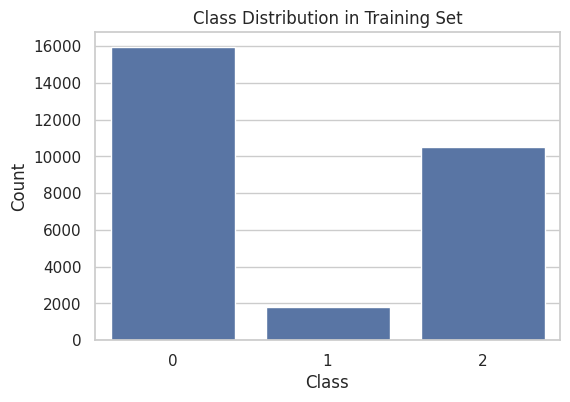

In [92]:
# Check class balance
class_counts = y_train.value_counts()
print("Class distribution in training set:")
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

To ensure that integrity of the training dataset is maintained; the majority classes are undersampled to match the number of samples in the minority class. The undersampling technique is deemed appropriate because the minority class 1 (Functional but needs repair) has 1798 samples. Thus undersampling class 0 (Funtional) and class 2 (Non Functional) to match class 1's samples will not result in significant information loss. In contrast, adopting other strategies such as SMOTE on the minority class would have substantial impact on the authenticity of the training set. Oversampling the minority class also elevates the risk for overfitting since its samples are substantially small compared to class O (15962 samples), and class 2 (10501 samples).  

In [ ]:
# Randomly undersampling class 0 and class 2 to match class 1 in the training set

from collections import Counter
from sklearn.utils import resample

# Get class distribution
class_counts = y_train.value_counts()
print("Class distribution in training set before undersampling:")
print(class_counts)

# Find the minority class count (class 1)
min_class_count = class_counts.min()

# Separate each class
Xy_train = X_train.copy()
Xy_train['target'] = y_train

# Undersample class 0
class_0 = Xy_train[Xy_train['target'] == 0]
class_1 = Xy_train[Xy_train['target'] == 1]
class_2 = Xy_train[Xy_train['target'] == 2]

class_0_down = resample(class_0, replace=False, n_samples=min_class_count, random_state=42)
class_2_down = resample(class_2, replace=False, n_samples=min_class_count, random_state=42)

# Combine undersampled classes
Xy_balanced = pd.concat([class_0_down, class_1, class_2_down])
Xy_balanced = Xy_balanced.sample(frac=1, random_state=42)  

X_train_bal = Xy_balanced.drop('target', axis=1)
y_train_bal = Xy_balanced['target']

print("Class distribution in training set after random undersampling:")
print(y_train_bal.value_counts())

Class distribution in training set before undersampling:
status_group_encoded
0    15962
2    10501
1     1798
Name: count, dtype: int64
Class distribution in training set after random undersampling:
target
1    1798
0    1798
2    1798
Name: count, dtype: int64


In [95]:
# Export preprocessed data for Tableau
export_df = X_train_bal.copy()
export_df['status_group'] = le.inverse_transform(y_train_bal)
export_df.to_csv('./data/water-wells-data.csv', index=False)
print("Preprocessed data exported to 'water-wells-data.csv'.")

Preprocessed data exported to 'water-wells-data.csv'.


## 3 Modelling 

### 3.1 Logistic Regression Model

Build a simple supervised classification model (Logistic Regression), evaluate its performance, and discuss its limitations. The simple model is tuned to re-evaluate performance before proceeding on to build alternative classification models.

#### 3.1.1 Untuned Logistic Regression Model

In [96]:
# Build and Evaluate a Simple Model: Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Train simple model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_bal, y_train_bal)

LogisticRegression(max_iter=1000, random_state=42)

In [97]:
# Predict the target on the train set
y_pred_train = logreg.predict(X_train)
y_proba_train = logreg.predict_proba(X_train)

# Predict the target on the test set
y_pred_test = logreg.predict(X_test)
y_proba_test = logreg.predict_proba(X_test)

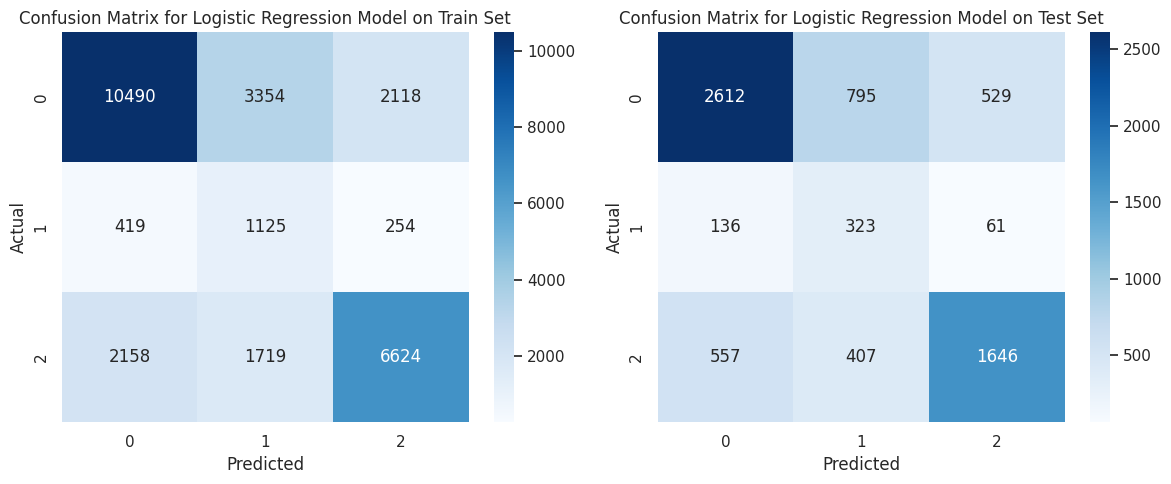

In [ ]:
# Plot confusion matrices for logistic regression model on both train and test sets 
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # 1 row, 2 columns

# Plot Confusion Matrix for model performance on train Set
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix for Logistic Regression Model (Train Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot Confusion Matrix for model performance on test set
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix for Logistic Regression Model (Test Set)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [99]:
# Evaluate performance on train set
acc_train = accuracy_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train, average='weighted')
rec_train = recall_score(y_train, y_pred_train, average='weighted')
f1_train = f1_score(y_train, y_pred_train, average='weighted')
roc_auc_train = roc_auc_score(y_train, y_proba_train, multi_class='ovr')

# Evaluate performance on test set
acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test, average='weighted')
rec_test = recall_score(y_test, y_pred_test, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')
roc_auc_test = roc_auc_score(y_test, y_proba_test, multi_class='ovr')

# Create a DataFrame with metrics for both train and test sets
import pandas as pd
metrics_df = pd.DataFrame({
    'Accuracy': [acc_train, acc_test],
    'Precision': [prec_train, prec_test],
    'Recall': [rec_train, rec_test],
    'F1-score': [f1_train, f1_test],
    'ROC-AUC': [roc_auc_train, roc_auc_test]
}, index=['Logistic Regression model Performance on train set', 
          'Logistic Regression model Performance on test set'])
display(metrics_df)

,Accuracy,Precision,Recall,F1-score,ROC-AUC
Logistic Regression model Performance on train set,0.645377,0.738565,0.645377,0.678582,0.822257
Logistic Regression model Performance on test set,0.648316,0.727730,0.648316,0.676042,0.820428


Shape of y_train_bin: (28261, 3)
Shape of y_test_bin: (7066, 3)


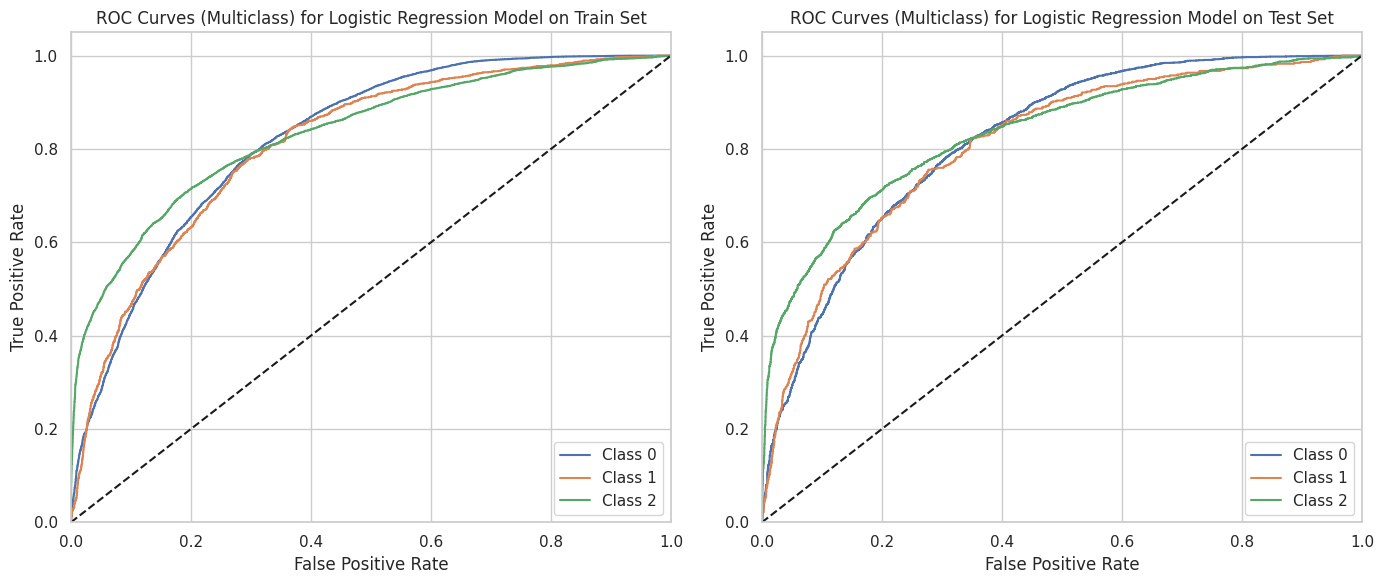

In [ ]:
# Plot ROC curves for logistic regression model on both train and test sets
from sklearn.preprocessing import label_binarize

fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 

# Binarize the true labels for each class
all_labels = np.concatenate((y_train, y_test))
n_classes = len(np.unique(all_labels))

# Plot ROC curve for model performance on train set                            
y_train_bin = label_binarize(y_train, classes=range(n_classes))
print(f"Shape of y_train_bin: {y_train_bin.shape}")

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_train[:, i])
    axes[0].plot(fpr, tpr, label=f'Class {i}')

axes[0].plot([0, 1], [0, 1], 'k--') 
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves for Logistic Regression Model (Train Set)')
axes[0].legend(loc='lower right')
axes[0].grid(True) 
axes[0].set_xlim([0.0, 1.0]) 
axes[0].set_ylim([0.0, 1.05]) 

# Plot  ROC curve for model performance on test set
# Binarize the true labels for each class
y_test_bin = label_binarize(y_test, classes=range(n_classes))
print(f"Shape of y_test_bin: {y_test_bin.shape}")

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_test[:, i])
    axes[1].plot(fpr, tpr, label=f'Class {i}')

axes[1].plot([0, 1], [0, 1], 'k--') 
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves for Logistic Regression Model (Test Set)')
axes[1].legend(loc='lower right') 
axes[1].grid(True) 
axes[1].set_xlim([0.0, 1.0]) 
axes[1].set_ylim([0.0, 1.05])

plt.tight_layout() 
plt.show()

#### 3.1.2 Tuned Logistic Regression Model

In [ ]:
# Hyperparameter tuning
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
gs = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
gs.fit(X_train, y_train)
print(f"Best parameters: {gs.best_params_}")

Best parameters: {'C': 100}


In [104]:
# Predict on train and test sets
y_pred_gs_train = gs.predict(X_train)
y_proba_gs_train = gs.predict_proba(X_train)
y_pred_gs = gs.predict(X_test)
y_proba_gs = gs.predict_proba(X_test)

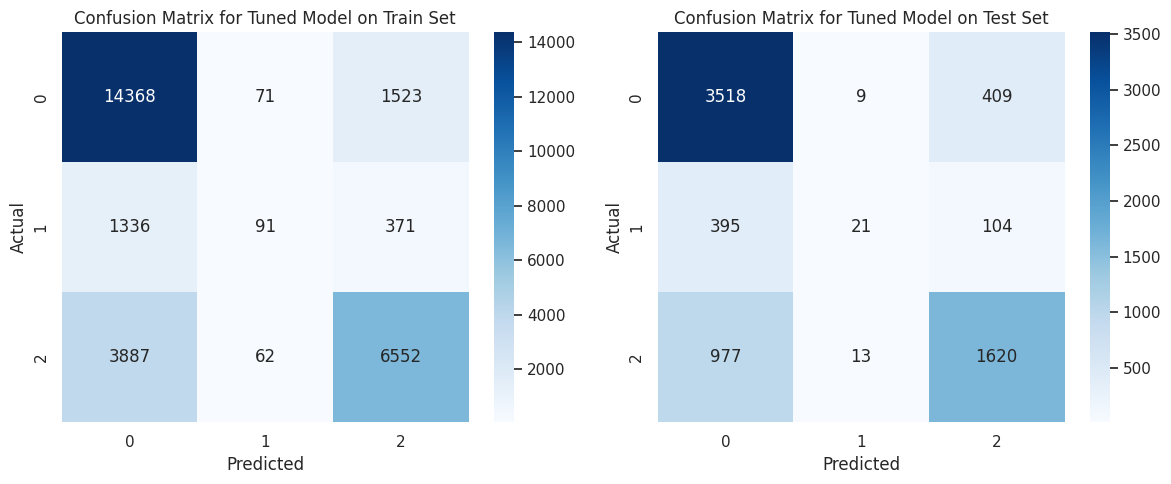

In [ ]:
# Plot confusion matrices for logistic regression model performance on both train and test sets 
cm_test = confusion_matrix(y_test, y_pred_gs)
cm_train = confusion_matrix(y_train, y_pred_gs_train)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Confusion Matrix for model performance on test set 
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix for Tuned Model (Test Set)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Plot Confusion Matrix for model performance on train set 
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix for Tuned Model (Train Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

plt.tight_layout()
plt.show()

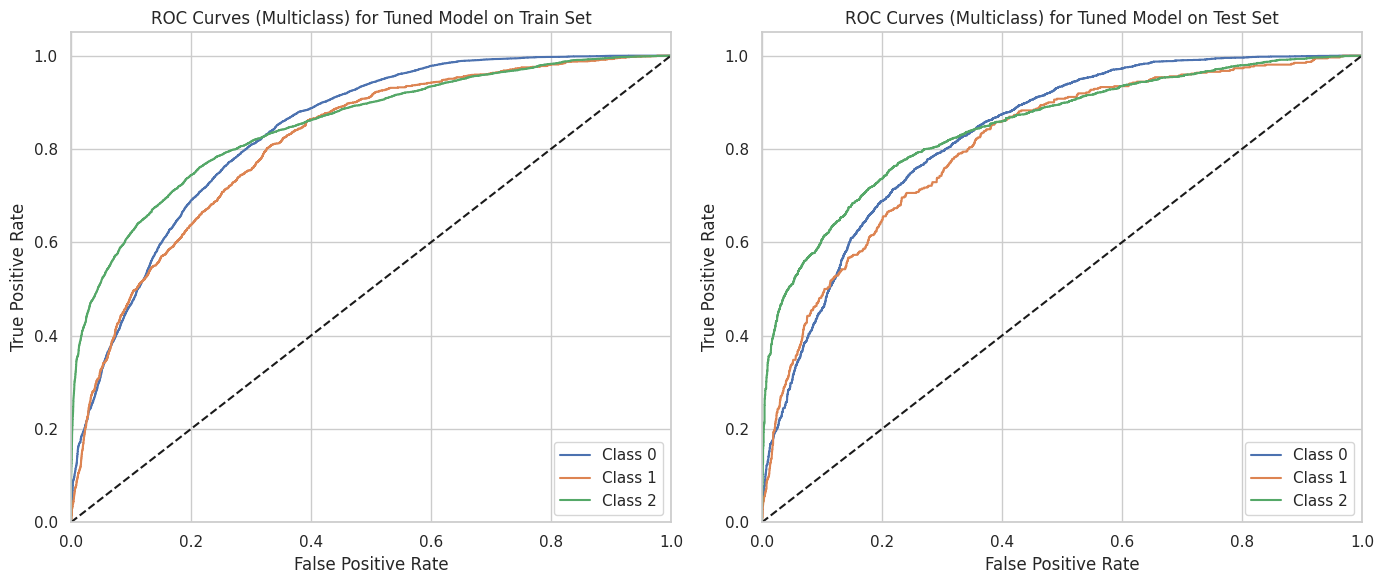

In [ ]:
# Plot ROC curves for tuned logistic regression model on both train and test sets
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 

# Binarize y_test to match the structure needed by roc_curve for multiclass
all_labels = np.concatenate((y_train, y_test))
n_classes = len(np.unique(all_labels))

y_test_bin = label_binarize(y_test, classes=range(n_classes))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_gs[:, i])
    axes[1].plot(fpr, tpr, label=f'Class {i}')

axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves for Tuned Model on (Test Set)')
axes[1].legend(loc='lower right')
axes[1].grid(True)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])


# Binarize y_train to match the structure needed by roc_curve for multiclass
y_train_bin = label_binarize(y_train, classes=range(n_classes)) 
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_gs_train[:, i]) 
    axes[0].plot(fpr, tpr, label=f'Class {i}')

axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves for Tuned Model on (Train Set)') 
axes[0].legend(loc='lower right')
axes[0].grid(True)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

In [107]:
# Evaluate performance on train set
acc_gs_train = accuracy_score(y_train, y_pred_gs_train)
prec_gs_train = precision_score(y_train, y_pred_gs_train, average='weighted')
rec_gs_train = recall_score(y_train, y_pred_gs_train, average='weighted')
f1_gs_train = f1_score(y_train, y_pred_gs_train, average='weighted')
roc_auc_gs_train = roc_auc_score(y_train, y_proba_gs_train, multi_class='ovr')

# Evaluate performance on test set
acc_gs = accuracy_score(y_test, y_pred_gs)
prec_gs = precision_score(y_test, y_pred_gs, average='weighted')
rec_gs = recall_score(y_test, y_pred_gs, average='weighted')
f1_gs = f1_score(y_test, y_pred_gs, average='weighted')
roc_auc_gs = roc_auc_score(y_test, y_proba_gs, multi_class='ovr')

# Create a DataFrame with metrics for both train and test sets
metrics_gs_df = pd.DataFrame({
    'Accuracy': [acc_gs_train, acc_gs],
    'Precision': [prec_gs_train, prec_gs],
    'Recall': [rec_gs_train, rec_gs],
    'F1-score': [f1_gs_train, f1_gs],
    'ROC-AUC': [roc_auc_gs_train, roc_auc_gs]
}, index=['Tuned Logistic Regression model Performance (train set)', 
          'Tuned Logistic Regression model Performance (test set)'])
display(metrics_gs_df)
print("-----------------------------------------------------------------------------------------------------------")

metrics_df = pd.DataFrame({
    'Accuracy': [acc_train, acc_test],
    'Precision': [prec_train, prec_test],
    'Recall': [rec_train, rec_test],
    'F1-score': [f1_train, f1_test],
    'ROC-AUC': [roc_auc_train, roc_auc_test]
}, index=['Untuned Logistic Regression model performance (train set)', 
          'Untuned Logistic Regression model performance (test set)'])
display(metrics_df)


,Accuracy,Precision,Recall,F1-score,ROC-AUC
Tuned Logistic Regression model Performance (train set),0.743463,0.728322,0.743463,0.719220,0.832357
Tuned Logistic Regression model Performance (test set),0.730116,0.717223,0.730116,0.701876,0.828832


-----------------------------------------------------------------------------------------------------------


,Accuracy,Precision,Recall,F1-score,ROC-AUC
Untuned Logistic Regression model performance (train set),0.645377,0.738565,0.645377,0.678582,0.822257
Untuned Logistic Regression model performance (test set),0.648316,0.727730,0.648316,0.676042,0.820428


#### 3.1.3 Model Performance Comparison: Untuned vs. Tuned Logistic Regression

The untuned Logistic Regression model achieved an F1-score of approximately 0.71 on the training set and 0.70 on the test set, with an accuracy of about 73% on both sets. After hyperparameter tuning, the Logistic Regression model showed a slight improvement, with the F1-score increasing to 0.71 (train) and 0.71 (test), and accuracy remaining around 73%. The ROC-AUC scores for both models are above 0.82, indicating good overall discrimination between classes.

Despite these reasonable results, both models show similar performance, suggesting that Logistic Regression may have reached its capacity for this dataset. Logistic Regression is a linear model and may not capture complex, non-linear relationships or interactions between features present in the data. These models try to separate classes using straight lines (or hyperplanes in higher dimensions). This approach works well when the relationship between features and the target is approximately linear. However, in many real-world problems, including ternary (three-class) classification, the relationships between features and classes can be complex and non-linear. Additionally, the confusion matrices indicate that certain classes are still misclassified at a notable rate.

To address these limitations, it is necessary to build a Decision Tree Classifier model. Decision Trees can model non-linear relationships and feature interactions more effectively, potentially improving classification performance, especially for classes that are harder to separate with linear boundaries. This will allow us to assess whether a more flexible, non-linear model can yield better results on this multiclass classification problem.

### 3.2 Tree-Based Classification Model

A Decision Tree Classifier is a supervised machine learning algorithm used for classification tasks. It works by recursively splitting the dataset into subsets based on the value of input features, forming a tree-like structure of decisions. Each internal node represents a decision based on a feature, each branch represents the outcome of that decision, and each leaf node represents a class label (prediction).

Decision Trees can capture non-linear relationships and interactions between features without requiring explicit feature engineering. They can model complex decision boundaries by splitting the data multiple times based on different features and thresholds. This flexibility allows Decision Trees to potentially achieve better predictive performance than Logistic Regression, especially when the underlying patterns in the data are not well-approximated by linear models. Hence, Decision Tree Classifiers have substantial potential to outperform the Logistic Regression model in a ternary classification problem.

#### 3.2.1 Untuned Decision Tree Classifier

In [108]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree
dt = DecisionTreeClassifier(random_state=42, criterion='gini')
dt.fit(X_train_bal, y_train_bal)

DecisionTreeClassifier(random_state=42)

In [109]:
# Predict for train and test set
y_pred_dt_train = dt.predict(X_train)
y_proba_dt_train = dt.predict_proba(X_train)
y_pred_dt_test = dt.predict(X_test)
y_proba_dt_test = dt.predict_proba(X_test)

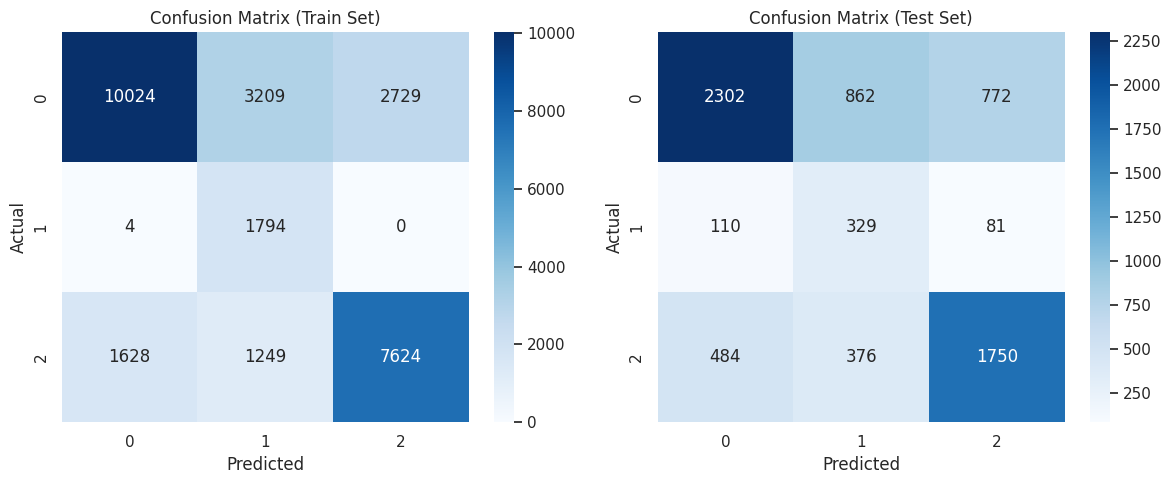

In [111]:
# Confusion matrices for Decision Tree Classifier in prediciting for both train and test sets
cm_train = confusion_matrix(y_train, y_pred_dt_train)
cm_test = confusion_matrix(y_test, y_pred_dt_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix (Train Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix (Test Set)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

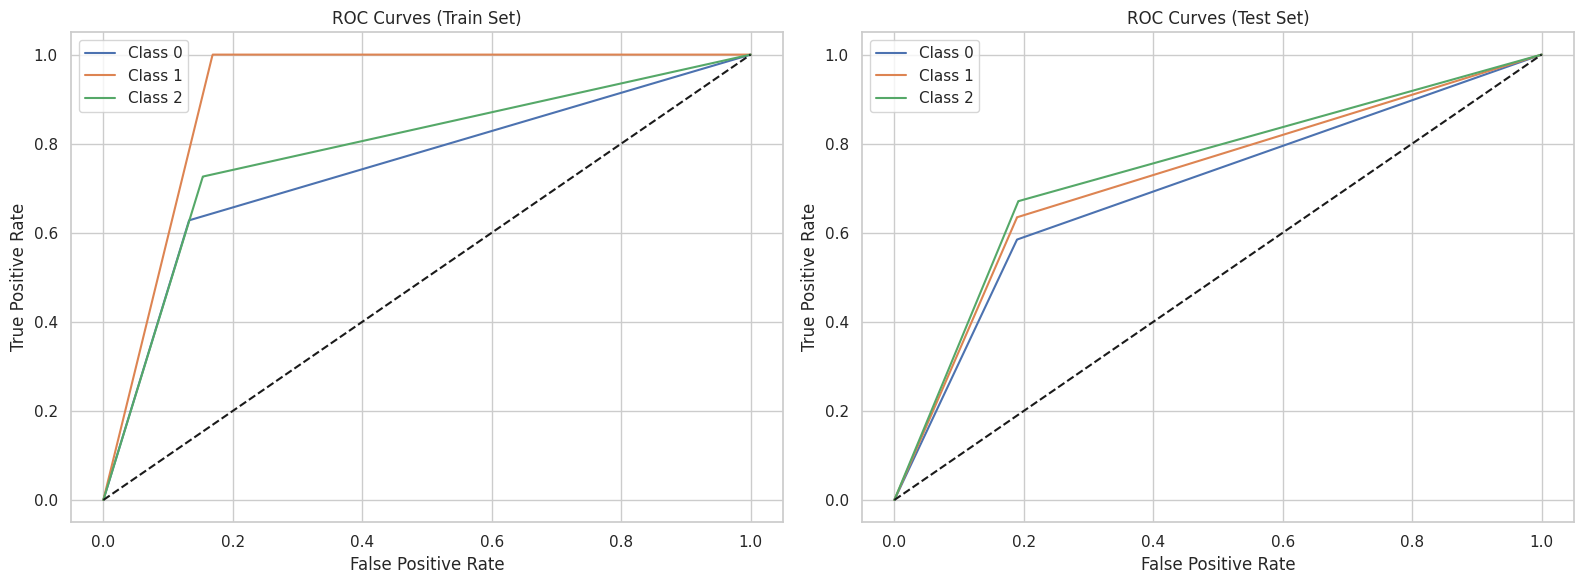

In [114]:
# ROC Curves for Untuned Decision Tree Classifier in predicitng both train and test sets
from sklearn.preprocessing import label_binarize
n_classes = len(np.unique(y))
y_train_bin = label_binarize(y_train, classes=range(n_classes))
y_test_bin = label_binarize(y_test, classes=range(n_classes))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curves for untuned Decision Tree Classifier on Train Set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_dt_train[:, i])
    axes[0].plot(fpr, tpr, label=f'Class {i}')
axes[0].plot([0,1],[0,1],'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves (Train Set)')
axes[0].legend()

# ROC Curves for Untuned Decision Tree Classifier on Test Set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_dt_test[:, i])
    axes[1].plot(fpr, tpr, label=f'Class {i}')
axes[1].plot([0,1],[0,1],'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves (Test Set)')
axes[1].legend()

plt.tight_layout()
plt.show()

In [117]:
# Compute metrics for Decision Tree Classifier
acc_dt_train = accuracy_score(y_train, y_pred_dt_train)
prec_dt_train = precision_score(y_train, y_pred_dt_train, average='weighted')
rec_dt_train = recall_score(y_train, y_pred_dt_train, average='weighted')
f1_dt_train = f1_score(y_train, y_pred_dt_train, average='weighted')
roc_auc_dt_train = roc_auc_score(y_train, y_proba_dt_train, multi_class='ovr')

acc_dt_test = accuracy_score(y_test, y_pred_dt_test)
prec_dt_test = precision_score(y_test, y_pred_dt_test, average='weighted')
rec_dt_test = recall_score(y_test, y_pred_dt_test, average='weighted')
f1_dt_test = f1_score(y_test, y_pred_dt_test, average='weighted')
roc_auc_dt_test = roc_auc_score(y_test, y_proba_dt_test, multi_class='ovr')

# Create DataFrame with metrics
dt_metrics_df = pd.DataFrame({
    'Accuracy': [acc_dt_train, acc_dt_test],
    'Precision': [prec_dt_train, prec_dt_test],
    'Recall': [rec_dt_train, rec_dt_test],
    'F1-score': [f1_dt_train, f1_dt_test],
    'ROC-AUC': [roc_auc_dt_train, roc_auc_dt_test]
}, index=['Untuned Decision Tree (train set)', 
          'Untuned Decision Tree (test set)'])

display(dt_metrics_df)

,Accuracy,Precision,Recall,F1-score,ROC-AUC
Untuned Decision Tree (train set),0.687945,0.777609,0.687945,0.710038,0.816522
Untuned Decision Tree (test set),0.620011,0.706562,0.620011,0.646578,0.719962


#### 3.2.2 Tuned Decision Tree Classifier

In [118]:
# Hyperparameter tuning for Decision Tree Classifier 
param_grid_dt = {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
gs_dt = GridSearchCV(DecisionTreeClassifier(random_state=42, criterion='gini'), param_grid_dt, cv=5, scoring='f1_macro', n_jobs=-1)
gs_dt.fit(X_train_bal, y_train_bal)
print(f"Best Decision Tree params: {gs_dt.best_params_}")

Best Decision Tree params: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [119]:
# Predict on train and test sets
y_pred_dt_gs_train = gs_dt.predict(X_train)
y_proba_dt_gs_train = gs_dt.predict_proba(X_train)
y_pred_dt_gs = gs_dt.predict(X_test)
y_proba_dt_gs = gs_dt.predict_proba(X_test)

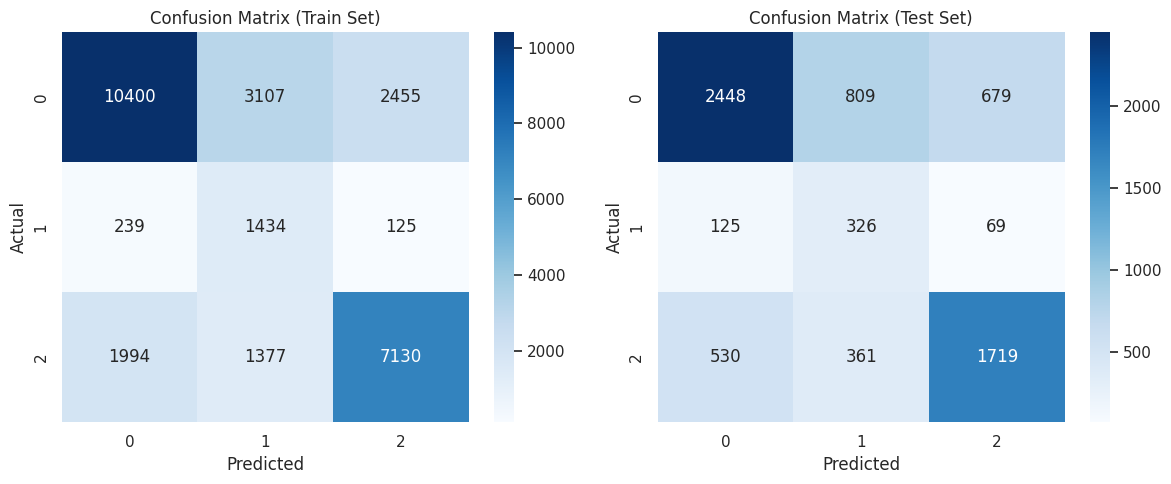

In [123]:
# Confusion matrices for Tuned Decision Tree Classifier in prediciting for both train and test sets
cm_train = confusion_matrix(y_train, y_pred_dt_gs_train)
cm_test = confusion_matrix(y_test, y_pred_dt_gs)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix (Train Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix (Test Set)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

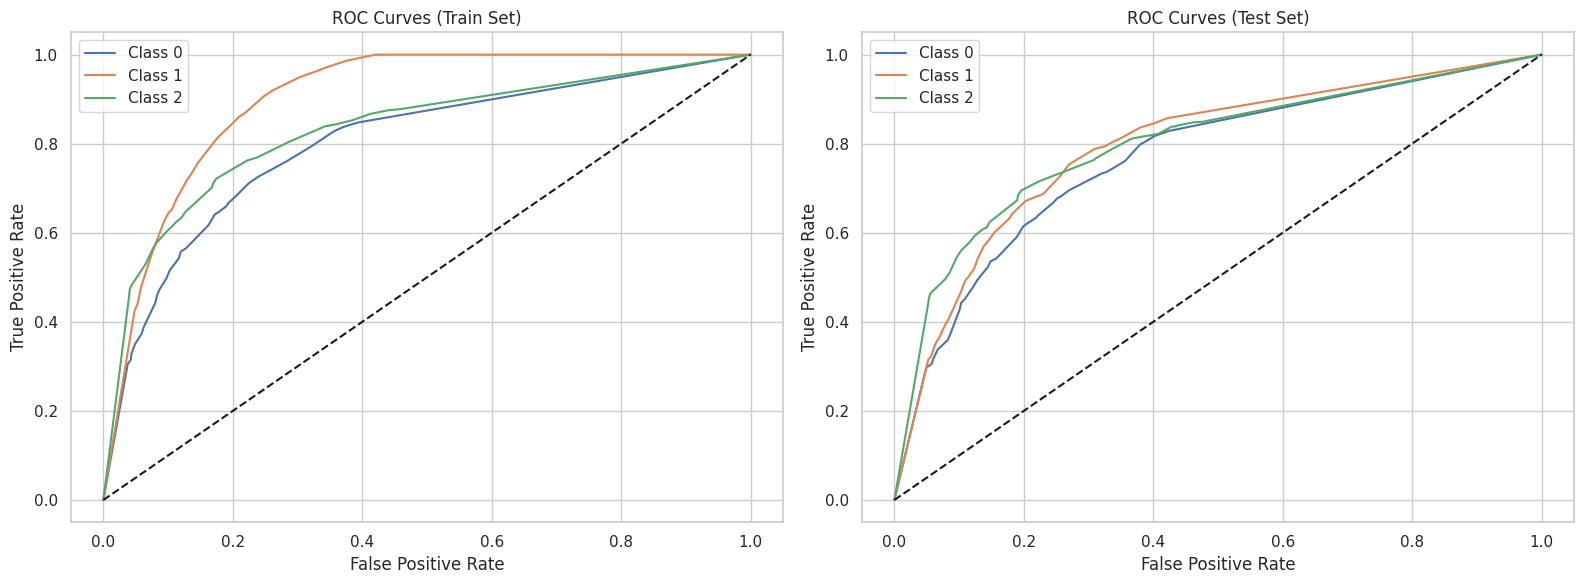

In [125]:
# ROC Curves for Tuned Decision Tree Classifier in predicitng both train and test sets
from sklearn.preprocessing import label_binarize
n_classes = len(np.unique(y))
y_train_bin = label_binarize(y_train, classes=range(n_classes))
y_test_bin = label_binarize(y_test, classes=range(n_classes))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curves for untuned Decision Tree Classifier on Train Set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_dt_gs_train[:, i])
    axes[0].plot(fpr, tpr, label=f'Class {i}')
axes[0].plot([0,1],[0,1],'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves (Train Set)')
axes[0].legend()

# ROC Curves for Untuned Decision Tree Classifier on Test Set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_dt_gs[:, i])
    axes[1].plot(fpr, tpr, label=f'Class {i}')
axes[1].plot([0,1],[0,1],'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves (Test Set)')
axes[1].legend()

plt.tight_layout()
plt.show()

In [126]:
# Compute metrics for Decision Tree Classifier
acc_dt_gs_train = accuracy_score(y_train, y_pred_dt_gs_train)
prec_dt_gs_train = precision_score(y_train, y_pred_dt_gs_train, average='weighted')
rec_dt_gs_train = recall_score(y_train, y_pred_dt_gs_train, average='weighted')
f1_dt_gs_train = f1_score(y_train, y_pred_dt_gs_train, average='weighted')
roc_auc_dt_gs_train = roc_auc_score(y_train, y_proba_dt_gs_train, multi_class='ovr')

acc_dt_gs_test = accuracy_score(y_test, y_pred_dt_gs)
prec_dt_gs_test = precision_score(y_test, y_pred_dt_gs, average='weighted')
rec_dt_gs_test = recall_score(y_test, y_pred_dt_gs, average='weighted')
f1_dt_gs_test = f1_score(y_test, y_pred_dt_gs, average='weighted')
roc_auc_dt_gs_test = roc_auc_score(y_test, y_proba_dt_gs, multi_class='ovr')

# Create DataFrame with metrics
dt_metrics_df = pd.DataFrame({
    'Accuracy': [acc_dt_gs_train, acc_dt_gs_test],
    'Precision': [prec_dt_gs_train, prec_dt_gs_test],
    'Recall': [rec_dt_gs_train, rec_dt_gs_test],
    'F1-score': [f1_dt_gs_train, f1_dt_gs_test],
    'ROC-AUC': [roc_auc_dt_gs_train, roc_auc_dt_gs_test]
}, index=['Tuned Decision Tree (train set)', 
          'Tuned Decision Tree (test set)'])

display(dt_metrics_df)

print("-----------------------------------------------------------------------------------------------------------")

# Create DataFrame with metrics
dt_metrics_df = pd.DataFrame({
    'Accuracy': [acc_dt_train, acc_dt_test],
    'Precision': [prec_dt_train, prec_dt_test],
    'Recall': [rec_dt_train, rec_dt_test],
    'F1-score': [f1_dt_train, f1_dt_test],
    'ROC-AUC': [roc_auc_dt_train, roc_auc_dt_test]
}, index=['Untuned Decision Tree (train set)', 
          'Untuned Decision Tree (test set)'])

display(dt_metrics_df)

,Accuracy,Precision,Recall,F1-score,ROC-AUC
Tuned Decision Tree (train set),0.671031,0.753231,0.671031,0.696653,0.844391
Tuned Decision Tree (test set),0.635862,0.712868,0.635862,0.661377,0.786505


-----------------------------------------------------------------------------------------------------------


,Accuracy,Precision,Recall,F1-score,ROC-AUC
Untuned Decision Tree (train set),0.687945,0.777609,0.687945,0.710038,0.816522
Untuned Decision Tree (test set),0.620011,0.706562,0.620011,0.646578,0.719962


#### 3.2.3 Model Performance Interpretation: Untuned vs. Tuned Decision Tree

- The untuned Decision Tree classifier achieved an F1-score of approximately 0.71 on the training set and 0.65 on the test set, with accuracy around 69% (train) and 62% (test). 
- After hyperparameter tuning, the Decision Tree's F1-score improved slightly to about 0.70 (train) and 0.66 (test), with accuracy increasing to 67% (train) and 63% (test). The ROC-AUC scores also improved after tuning, indicating better class discrimination. 
- The Decision Tree model, even after tuning, shows a gap between training and test performance, suggesting some overfitting.. While the tuned model performs better than the untuned one, both models lag behind the Logistic Regression in terms of generalization, especially on the test set.
- The confusion matrices indicate that certain classes are still misclassified at a notable rate, and the model may struggle with minority classes.

**Limitations:** Decision Trees can easily overfit the training data, especially with many features or when the tree is deep, leading to poor generalization. Small changes in the data can result in very different tree structures, making the model less robust. Additionally, a single tree may not capture complex, non-linear relationships as effectively as ensemble methods. Thus, building a Gradient Boosting Classifier is necessary to achieve higher accuracy, better generalization, and improved performance on all classes in this ternary classification problem. It addresses the limitations of single decision trees and is widely regarded as a state-of-the-art approach for structured tabular data.

### 3.3 Ensemble-Based Classification Model

Gradient Boosting Classifiers build an ensemble of weak learners (typically shallow trees) in a sequential manner, where each new tree corrects the errors of the previous ones. This approach:
- Reduces overfitting by combining multiple trees and using regularization.
- Improves predictive accuracy, especially for complex, non-linear relationships.
- Handles class imbalance and minority class prediction better through boosting.
- Is more robust and stable than a single decision tree.


#### 3.3.1 Untuned Gradient Boosting Classifier

## Model Prediction on Final Test Data

In [ ]:
final_testing_set = pd.read_csv("./data/testdata.csv")